# Image Pre processing
Because noone wants 50+ Gb of image data

* This notebook will process the images so that to crops out the interesting parts and saves it as numpy arrays, ready to be loaded into the analysis scripts of your chouce
* Normalisation to white source is done as if the source was uniform

* The script expects youd data to be organised in the following format:
```
Root_data_folder    
│
└───Substrate_1
│   └───2  
│       └───oc
│       │   │   LED_power_suply.csv
│       │   │   source_meter.csv
│       │   └───camera
│       │       │     camera_setting_dump.txt
│       │       │     exposure_list.csv
│       │       │     OC_LED=2.580_0.tif
│       │       │     OC_LED=2.580_1.tif
│       │       │     ...
│       └───sc
│       │   │   LED_power_suply.csv
│       │   │   ...
│       └───vsweep   
│       │...
└───Substrate_2
│   │   ...
│    ...
└───white
│   │   ...
```
* Not all the csv/txt files need to exist, but if they exist in the above format, they will be copied over in the processed folder
* The processed images are saved as numpy files
    * file name is in the format <em>sourcemeter</em>\\<em>powermeter measured flux</em>

### Some instructions: 
* Please run each cell in order, following the instructions
* Press cntrl+enter to run a cell
* When prompted enter information into the feilds and press enter
* If you go back and re run a cell, that's fine but you have to run every cell after that again, and in order

This might break if all these files are not there! If you want to edit this code definately go ahead, a bunch of the functions live in seperate .py files, BUT please make a copy!!!


In [1]:
# Some imports:
from external_imports import *
from image_process import *
from general_data_process import *

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

### Data/save path
* Edit to add where your data lives and where the saved data is going to live:

In [2]:
datapath = r"C:\SCRATCH\EL_paper\1.6eVyen\polymerset_22_08_2021"
savepath = r"D:\PROCESSED\Akash\EL_PL_setup_paper\1.6eVyen"

### White reference
* First thing we need to do is determine the center of the beam spot, for which we will use the 'white reference'
* Make the rectangle bound your white reference, and then press save 'crop size'
* This calculates where the center of the distribution is, which the whole calibration hinges on so be careful!
* Since we just need the center, what you choose as the 'edge' is not important as long as you are consistant

In [3]:
# Filenames for white ref + bg:
whitefiles = find_tif(datapath+r"\white\camera")
whitereffiles = find_tif(datapath+r"\white\camera\refs")

# Open and average
white = averager(datapath+r"\white\camera", whitefiles)
white_ref = averager(datapath+r"\white\camera\refs", whitereffiles)
white -= white_ref
white = nd.gaussian_filter(white,10) # To remove texture of the reference

crop([np.array(white)*(2**(8)/np.max(white))],['White reference'], callback=callback_return_size)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

Now run this to calculate the calibation:

In [4]:
center_row = (white_buffer[0]+white_buffer[1])/2
center_col = (white_buffer[2]+white_buffer[3])/2
# Non uniformity :
white_norm = white_nonunif(white, center_row, center_col, photodiode_diam_pix)

### Load filenames
* Next run the following, it crawls the datapath and organises the images into catagories, ready to process

In [5]:
path_db = path_process(datapath)

names_of_crop = []
images_for_crop = []
for key in path_db.keys():
    for pix in path_db[key]:
        subpath = f"{datapath}\\{key}\\{pix}\\oc\\camera"
        name = f"{key}, Pixel {pix}"
        image = image_for_cropping(subpath)

        names_of_crop.append(name)
        images_for_crop.append(np.array(image, dtype=np.uint8))

### Crop active area
* Most of the image is useless, so crop out for each pixel the activve area
* Note: Please crop WITHIN pixel, ie, make sure the whole rectangle is inside the pixel, not bounding it. 
    * This is bacause we will take a mean of the image in calculations, and we don't want any edge nonsense in it
    * We will loose some area but it's fine
* Crop, press 'save crop size', and keep going for all pixels until 'Made it through all the tests. Printing cropped results below.' message shows

In [6]:
crop(images_for_crop,names_of_crop,callback=callback_return_pix_size)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

### Check crops (optional)
* It's a good idea to run bellow, and make sure it all looks sensible. Redo them if needed

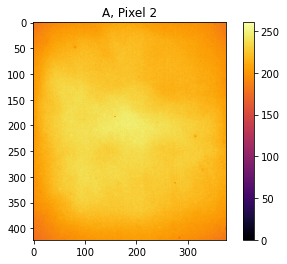

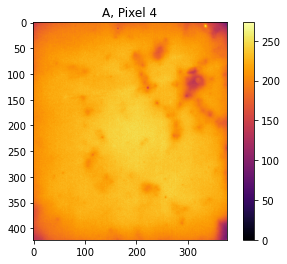

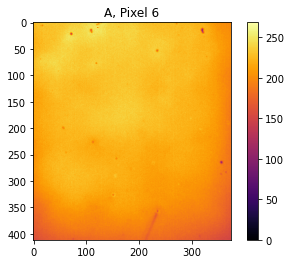

In [9]:
for i, key in enumerate(cell_borders.keys()):
    rmin = cell_borders[key][0]
    rmax = cell_borders[key][1]
    cmin = cell_borders[key][2]
    cmax = cell_borders[key][3]
    
    
    imarr = images_for_crop[i][rmin:rmax, cmin:cmax]
    
    plt.imshow(imarr,vmin=0, vmax=np.mean(imarr)+3*np.std(imarr),cmap="inferno")
    plt.colorbar()
    plt.title(names_of_crop[i])
    plt.show()

### Process
* Finally run the last cell to do the actual processing

In [8]:
measurement_subfolders = ['oc', 'sc', 'vsweep_f', "vsweep_b", 'sr']

# Just going to define this as a functiuon so later we can parallelise it using joblib:
def process_one_image(key, datapath,nested_path,imarr, white_norm, ref, exposures, rmin, rmax, cmin, cmax):
    # Open an image:
    imarr = averager(f"{datapath}\\{nested_path}\\camera", repeat_db[key])
    # Figure out voltage:
    nominal_v = key.split('_')[1]
    # Figure out source meter setting:
    sm =  key.split('_')[0]

    # Generate beam corrected cropped image + Powermeter flux:
    flux, imarr_corrected = beam_correct(imarr, white_norm, ref, float(nominal_v), rmin, rmax, cmin, cmax)
    
    # Save:
    keystr = "{:.3f}".format(float(nominal_v))
    filename = f"{sm}_{flux}_{exposures[keystr]}_"
    np.save(f"{savepath}\\{nested_path}\\{filename}",imarr_corrected)


for key in path_db.keys():
    for pix in path_db[key]:       
        # Crop dimentions pull:
        crop_key = f"{key}, Pixel {pix}"
        rmin = cell_borders[crop_key][0]
        rmax = cell_borders[crop_key][1]
        cmin = cell_borders[crop_key][2]
        cmax = cell_borders[crop_key][3]
        
        # Loop over all the sub measurements taken (OC, SC, etc):
        for measurement_subfolder in measurement_subfolders:
            try:
                # db for which files were repeats:
                nested_path = f"{key}\\{pix}\\{measurement_subfolder}" 
                repeat_db = image_intsweep_name_parser(f"{datapath}\\{nested_path}\\camera")

                # extract the exposures for filename:
                exposures = {}
                if os.path.isfile(f"{datapath}\\{nested_path}\\camera\\exposure_list.csv"):
                    with open(f"{datapath}\\{nested_path}\\camera\\exposure_list.csv",'r') as file:
                        reader = csv.reader(file)
                        for row in reader:
                            exposures["{:.3f}".format(float(row[0]))] = row[1]
                else:
                    for nominal_v in np.arange(2.4,3.1,0.001):
                        exposures["{:.3f}".format(nominal_v)] = get_cam_exposure(f"{datapath}\\{nested_path}")

                # Make the directory for saving this measurement if not already there
                if not os.path.isdir(f"{savepath}\\{nested_path}"):
                    os.makedirs(f"{savepath}\\{nested_path}") # make the path

                # Copy all the cvs/txt files:
                copy_led_sm_data(f"{datapath}\\{nested_path}",f"{savepath}\\{nested_path}")

                # Generate dark reference
                ref_files = find_tif(f"{datapath}\\{nested_path}\\camera\\refs")
                ref = averager(f"{datapath}\\{nested_path}\\camera\\refs",ref_files)

                # Looping over all the sweep params, parallel:
                Parallel(n_jobs=num_cores)(delayed(process_one_image)(key2,datapath,nested_path,imarr, white_norm, ref, exposures, rmin, rmax, cmin, cmax) for key2 in repeat_db.keys())
                # Save white cropped to same region as pixel image:
                white_cropped = white[rmin:rmax,cmin:cmax]
                np.save(f"{savepath}\\{key}\\{pix}\\white", white_cropped)
            except:
                pass

# Save white reference parameters:
white_exposure = get_cam_exposure(f"{datapath}\\white")
white_nominal_v = whitefiles[0].split('_')[1].split('=')[1]
white_flux_scale = ledf(float(white_nominal_v))

with open(f"{savepath}\\white_params.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Exposure', white_exposure])
    writer.writerow(['Flux scale', white_flux_scale])
        

### How is the data saved?

* Following save format is used:

```
Root_save_folder  
│   
│   white_params.csv
│   
└───Substrate_1
│   └───2 
│   │   │   white.npy
│   │   └───oc
│   │   │   │   LED_power_suply.csv
│   │   │   │   source_meter.csv
│   │   │   │   camera_setting_dump.txt
│   │   │   │   exposure_list.csv
│   │   │   │   OC_1.027180771003644e+17_.npy
│   │   │   │   OC_1.273380059086228e+16_.npy
│   │   │   │   ...
│   │   │
│   │   └───sc
│   │   │   │   ...
│   │   │
│   │   └───vsweep  
│   │   │   │   source_meter.csv
│   │   │   │   camera_setting_dump.txt
│   │   │   │   0.000_1.3184070393385995e+17_.npy
│   │   │   │   0.050_1.3184070393385995e+17_.npy
│   │   │
│   │   │...
│   │
│   │...     
│
└───Substrate_2
    │   ...
     ...

```

* white_params.csv holds the LED flux and exposure time used for the 